# RSI指標+簡單移動平均線策略（作業版）


本次策略使用兩個因子：

1. RSI指標，(英文全名：Relative Strength Index)，中文稱為「相對強弱指標」，是一種以股價漲跌為基礎，在一段時間內的收盤價，用於評估價格變動的速度（快慢) 與變化 (幅度) 的技術分析工具，RSI藉由計算一段期間內股價的漲跌變化，判斷最近的趨勢屬於偏強 (偏多) 還是偏弱 (偏空)。

2. 簡單移動平均線（SMA），(英文全名：Simple Moving Average)，是指一段特定的時間內，對價格進行簡單平均計算統計出來的數值連線，一般是用股票收盤價來計算。簡單移動平均線是觀察價格波動的一個最基礎指標之一。
   
```
os.environ['TEJAPI_KEY'] = "your key" ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw" ==> 導航至 tej api 網域。
```

In [1]:
import os
os.environ['TEJAPI_KEY'] = "esG0D3Ustb9UJ2ZOhV5DsRQWJpp2nI" 
os.environ['TEJAPI_BASE'] ="https://api.tej.com.tw"

In [2]:
# 引入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return

In [3]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2022-01-01'
end = '2022-12-31'
pool = get_universe(start, end, mkt = 'TWSE', stktp_c = '普通股', main_ind_c = 'M1700 化學生技醫療')  # 填入：篩選股票池所需的參數
print(f'共有 {len(pool)} 檔股票：\n', pool)

共有 58 檔股票：
 ['1598', '1701', '1707', '1708', '1709', '1710', '1711', '1712', '1713', '1714', '1717', '1718', '1720', '1721', '1722', '1723', '1725', '1726', '1727', '1730', '1731', '1732', '1733', '1734', '1735', '1736', '1752', '1760', '1762', '1773', '1776', '1783', '1786', '1789', '1795', '3164', '3705', '3708', '4104', '4106', '4108', '4119', '4133', '4142', '4155', '4164', '4720', '4722', '4737', '4739', '4746', '4755', '4764', '4766', '4770', '6491', '6782', '6796']


In [4]:
import tejapi
from zipline.api import *
tejapi.ApiConfig.api_key = os.environ['TEJAPI_KEY']
tejapi.ApiConfig.api_base= os.environ['TEJAPI_BASE']
tejapi.ApiConfig.ignoretz = True

In [5]:
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')

tickers = ' '.join(pool)

# IX0019: 化學生技醫療指數
os.environ['ticker'] = tickers+' IX0019'
os.environ['mdate'] = start+' '+end

tickers

'1598 1701 1707 1708 1709 1710 1711 1712 1713 1714 1717 1718 1720 1721 1722 1723 1725 1726 1727 1730 1731 1732 1733 1734 1735 1736 1752 1760 1762 1773 1776 1783 1786 1789 1795 3164 3705 3708 4104 4106 4108 4119 4133 4142 4155 4164 4720 4722 4737 4739 4746 4755 4764 4766 4770 6491 6782 6796'

In [6]:
!zipline ingest -b tquant 

Merging daily equity files:


[2024-01-17 07:00:17.559037] INFO: zipline.data.bundles.core: Ingesting tquant.


In [7]:
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.factors import RSI , SimpleMovingAverage   # 填入：這次使用的 pipeline 因子
from zipline.pipeline.filters import StaticAssets

bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IX0019',as_of_date = None)

# 客製化因子：取得前一個日期的均線和後一個均線的差值，以此取得斜率
class SMA_diff(CustomFactor):
    
    def compute(self, today, assets, out, data):

        out[:] = (np.nanmean(data[1:self.window_length], axis=0) -\
                   np.nanmean(data[0:int(self.window_length)-1], axis=0)).round(3)

# 製作 pipeline
def make_pipeline(rsi_window_length, sma_window_length):
    
    rsi = RSI(inputs = [TWEquityPricing.close], window_length = rsi_window_length)
    sma = SimpleMovingAverage(inputs = [TWEquityPricing.close], window_length = sma_window_length)
    curr_price = TWEquityPricing.close.latest
    SMA_slope = SMA_diff(inputs=[TWEquityPricing.close], window_length = sma_window_length + 1)
    
    return Pipeline(
        columns = {
            "RSI": rsi,
            "SMA": sma,
            'SMA_slope': SMA_slope,
            'curr_price':  curr_price    # 填入： pipeline 列表的欄位名稱(key)與值(value)
        },
        screen = ~StaticAssets([benchmark_asset])
    )
    
my_pipeline = run_pipeline(make_pipeline(10, 14), start_dt, end_dt)

# 2022/09/26 交易日股票池內共 58 檔股票的 RSI、SMA、SMA_slope、curr_price 資訊如下表
my_pipeline.head(9993).tail(57)

# pipeline = make_pipeline(10, 14)

RSI         SMA  SMA_slope  \
2022-09-26 00:00:00+00:00 Equity(0 [1598])   29.032258   41.592857     -0.250   
                          Equity(1 [1701])    6.060606   22.435714     -0.068   
                          Equity(2 [1707])   23.529412  141.857143     -0.429   
                          Equity(3 [1708])   37.254902   49.075000     -0.068   
                          Equity(4 [1709])    0.000000   24.267857     -0.071   
                          Equity(5 [1710])   47.500000   18.289286      0.021   
                          Equity(6 [1711])   25.000000   19.917857     -0.093   
                          Equity(7 [1712])   36.111111   43.064286     -0.207   
                          Equity(8 [1713])   57.894737   25.057143      0.007   
                          Equity(9 [1714])   17.460317    9.200000     -0.018   
                          Equity(10 [1717])  27.160494   33.207143     -0.050   
                          Equity(11 [1718])  31.707317    8.057857     -0.005   
                          Equity(12 [1720])   7.812500   47.564286     -0.168   
                          Equity(13 [1721])  19.230769   16.253571     -0.125   
                          Equity(14 [1722])   4.444444   60.585714     -0.271   
                          Equity(15 [1723])  28.571429  113.607143     -0.250   
                          Equity(16 [1725])  27.536232   22.807143     -0.157   
                          Equity(17 [1726])  26.666667   71.078571     -0.029   
                          Equity(18 [1727])  31.034483   29.567857     -0.179   
                          Equity(19 [1730])  38.095238   56.950000     -0.071   
                          Equity(20 [1731])  26.666667   18.617857     -0.025   
                          Equity(21 [1732])  23.444976   34.417857     -0.543   
                          Equity(22 [1733])  34.615385   26.867857     -0.136   
                          Equity(23 [1734])  21.978022   32.192857     -0.239   
                          Equity(24 [1735])  54.166667   14.975000      0.014   
                          Equity(25 [1736])  42.857143   70.563864      1.049   
                          Equity(26 [1752])  17.910448   38.157143     -0.179   
                          Equity(27 [1760])  46.296296  140.357143     -1.357   
                          Equity(28 [1762])   8.771930   56.978571     -0.400   
                          Equity(29 [1773])  38.888889  128.892857     -0.500   
                          Equity(30 [1776])  35.714286   18.057143     -0.025   
                          Equity(31 [1783])  23.353293   46.507143     -0.354   
                          Equity(32 [1786])  33.333333   46.821429     -0.393   
                          Equity(33 [1789])  15.277778   26.603571     -0.286   
                          Equity(34 [1795])  52.127660  164.964286     -0.286   
                          Equity(35 [3164])  48.648649   27.439286      0.011   
                          Equity(36 [3705])  11.111111   40.764286     -0.050   
                          Equity(37 [3708])  66.502463   91.628571      0.286   
                          Equity(38 [4104])  12.500000   66.335714     -0.150   
                          Equity(39 [4106])  25.333333   26.496429     -0.182   
                          Equity(40 [4108])  36.666667   20.296429     -0.014   
                          Equity(41 [4119])  42.016807   90.178571      0.257   
                          Equity(42 [4133])  11.111111   39.996429     -0.711   
                          Equity(43 [4142])  13.207547   37.117857     -0.429   
                          Equity(44 [4155])  76.119403   25.228571      0.132   
                          Equity(45 [4164])  37.777778   44.628571     -0.100   
                          Equity(46 [4720])  33.333333   16.242857     -0.193   
                          Equity(47 [4722])  15.789474   36.678571     -0.057   
                          Equity(48 [4737])  34.939759   82.800000     -0.729   
 

In [8]:
from zipline.finance.slippage import VolumeShareSlippage
from zipline.finance.commission import PerDollar

def initialize(context):
    
    set_slippage(VolumeShareSlippage(volume_limit=1.0, price_impact=0))
    set_commission(PerDollar(cost=0.0029))
    attach_pipeline(make_pipeline(10, 14), 'mystrats')  # 填入：前面 pipeline 中設定的 RSI 和 SMA 的 window_length
    bundle_data = bundles.load('tquant')
    set_benchmark(symbol('IX0019'))  # 填入：這次使用的報酬指數

In [9]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')

    for i in out_dir.index:
        sym = i.symbol
        rsi = out_dir.loc[i, "RSI"]
        sma = out_dir.loc[i, "SMA"]
        sma_slope = out_dir.loc[i, 'SMA_slope']
        curr_price = out_dir.loc[i, 'curr_price']
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        buy, sell = False, False
        
        # 將每一檔股票的狀態紀錄進來
        record(
           **{
                f'price_{sym}':curr_price,
                f'rsi_{sym}':rsi,
                f'sma_{sym}':sma,
                f'sma_slope_{sym}':sma_slope,
                f'buy_{buy}':buy,
                f'sell_{sym}':sell
            }
        )

        # RSI指標不大於35、均線斜率為正且有足夠資金購買該股一張股票
        if (rsi<=35) and (sma_slope > 0) and (cash_position >= curr_price* 1000):    # 填入：根據上一行註解的交易邏輯回答
            order(i, 1000)
            buy = True
            record(
                **{
                    f'buy_{sym}':buy
                }
            )
        else:
            pass

        # RSI指標不小於75、均線斜率為負且有至少一張股票
        if (rsi >= 75) and (sma_slope > 0) and (cash_position >= curr_price* 1000):    # 填入：根據上一行註解的交易邏輯回答
            order_target(i, 0)
            sell = True
            record(
                **{
                    f'sell_{sym}':sell
                }
            )
        else:
            pass

In [10]:
def analyze(context, perf):
    pass

In [11]:
from zipline import run_algorithm
results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data
)

# results

In [12]:
# 回測結果
results

,period_open,period_close,longs_count,shorts_count,long_value,short_value,starting_cash,ending_value,pnl,long_exposure,...,buy_1598,buy_1713,buy_1726,buy_4142,buy_1735,price_6782,rsi_6782,sma_6782,sma_slope_6782,sell_6782
2022-01-03 13:30:00+08:00,2022-01-03 09:01:00+08:00,2022-01-03 13:30:00+08:00,0,0,0.0,0.0,1.000000e+07,0.0,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04 13:30:00+08:00,2022-01-04 09:01:00+08:00,2022-01-04 13:30:00+08:00,0,0,0.0,0.0,1.000000e+07,0.0,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05 13:30:00+08:00,2022-01-05 09:01:00+08:00,2022-01-05 13:30:00+08:00,0,0,0.0,0.0,1.000000e+07,0.0,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06 13:30:00+08:00,2022-01-06 09:01:00+08:00,2022-01-06 13:30:00+08:00,0,0,0.0,0.0,1.000000e+07,0.0,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07 13:30:00+08:00,2022-01-07 09:01:00+08:00,2022-01-07 13:30:00+08:00,0,0,0.0,0.0,1.000000e+07,0.0,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26 13:30:00+08:00,2022-12-26 09:01:00+08:00,2022-12-26 13:30:00+08:00,13,0,1449100.0,0.0,8.427883e+06,1449100.0,6400.000,1449100.0,...,True,True,True,True,True,290.0,13.815789,327.785714,-2.821,False
2022-12-27 13:30:00+08:00,2022-12-27 09:01:00+08:00,2022-12-27 13:30:00+08:00,14,0,1487200.0,0.0,8.427883e+06,1487200.0,18242.580,1487200.0,...,True,True,True,True,True,286.0,6.081081,324.107143,-3.679,False
2022-12-28 13:30:00+08:00,2022-12-28 09:01:00+08:00,2022-12-28 13:30:00+08:00,15,0,1511400.0,0.0,8.408026e+06,1511400.0,-4382.650,1511400.0,...,True,True,True,True,True,301.0,22.674419,321.571429,-2.536,False
2022-12-29 13:30:00+08:00,2022-12-29 09:01:00+08:00,2022-12-29 13:30:00+08:00,16,0,1549350.0,0.0,8.379443e+06,1549350.0,-9637.605,1549350.0,...,True,True,True,True,True,295.5,20.441989,319.928571,-1.643,False


Start date,2022-01-03
End date,2022-12-30
Total months,11
,Backtest
Annual return,-1.201%
Cumulative returns,-1.173%
Annual volatility,5.544%
Sharpe ratio,-0.19
Calmar ratio,-0.28
Stability,0.17
Max drawdown,-4.236%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.24,2022-09-14,2022-10-26,NaT,NaN
1,4.22,2022-02-11,2022-07-12,2022-09-14,148
2,0.04,2022-01-12,2022-02-07,2022-02-10,15
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,-0.00%,-1.47%,1.49%


Top 10 long positions of all time,max
sid,
6491,13.64%
4770,8.18%
1795,6.96%
1760,5.38%
4755,4.58%
1773,4.24%
1707,2.99%
3708,2.99%
4119,2.83%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
6491,13.64%
4770,8.18%
1795,6.96%
1760,5.38%
4755,4.58%
1773,4.24%
1707,2.99%
3708,2.99%
4119,2.83%


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


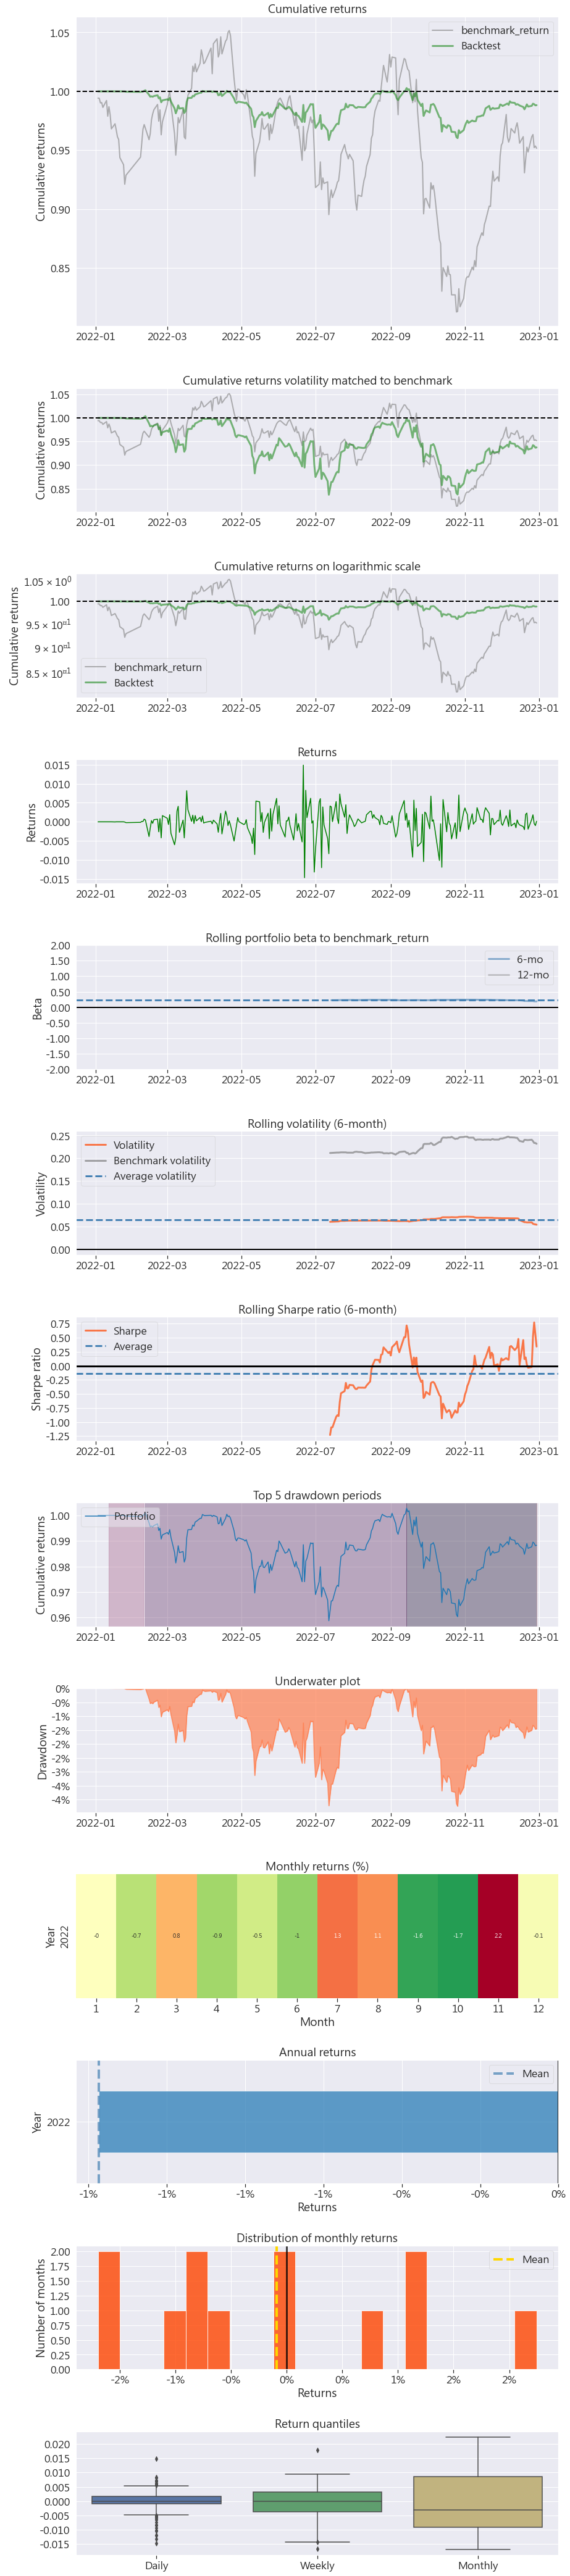

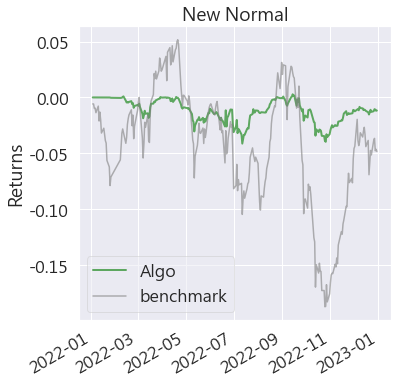

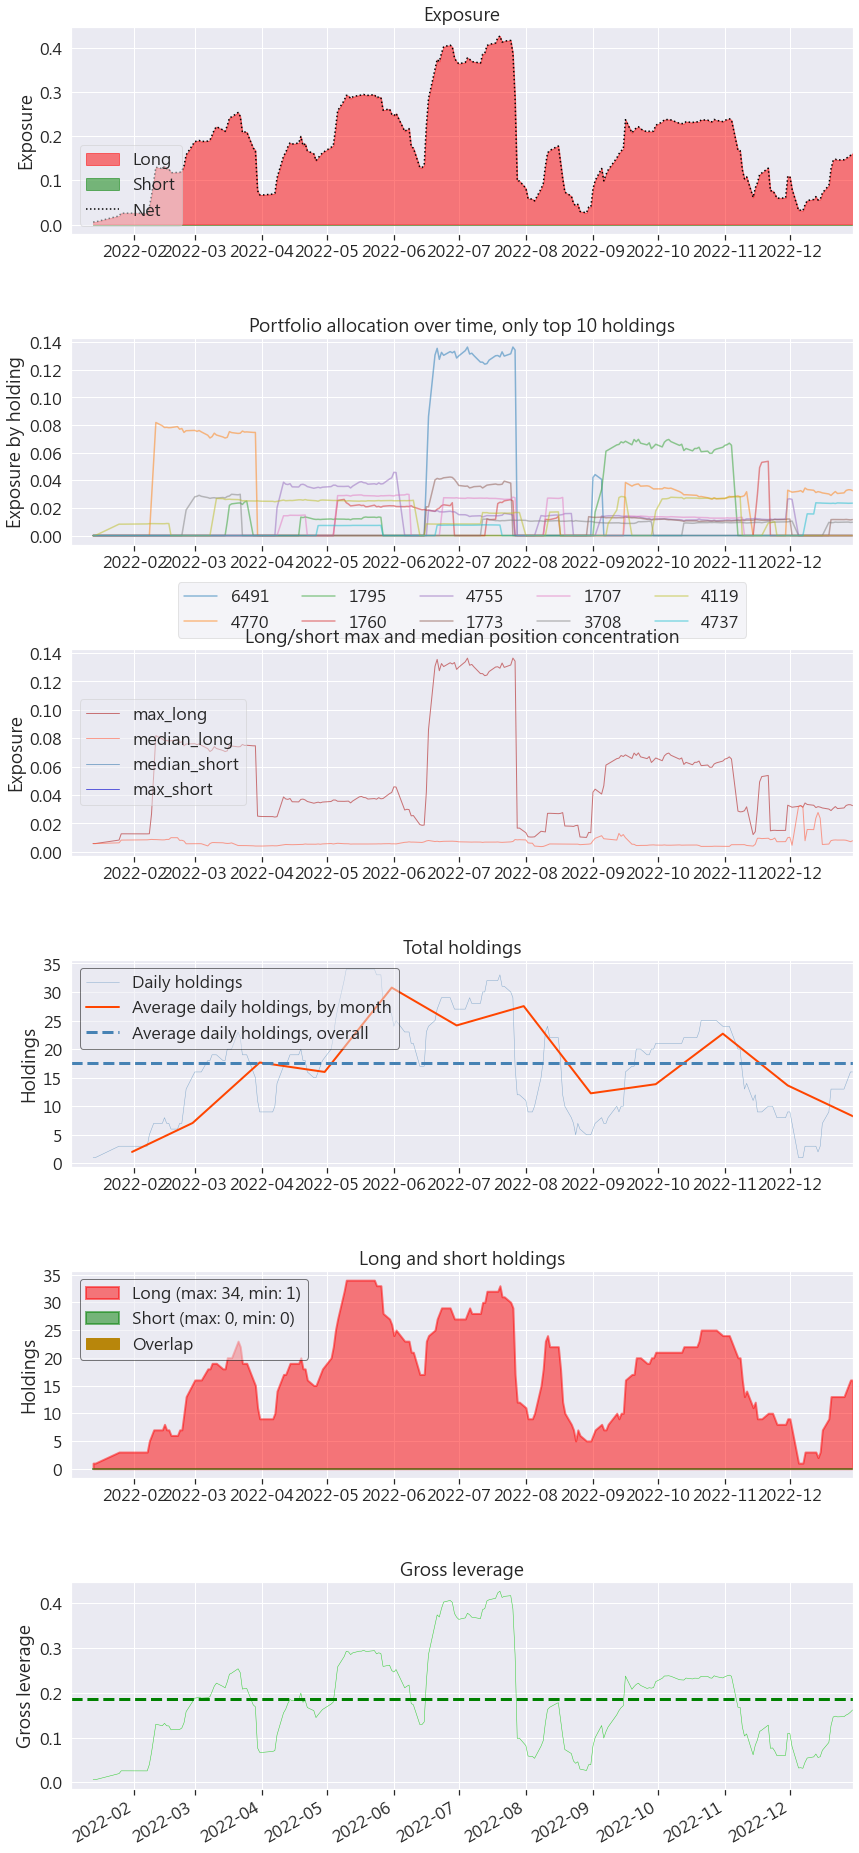

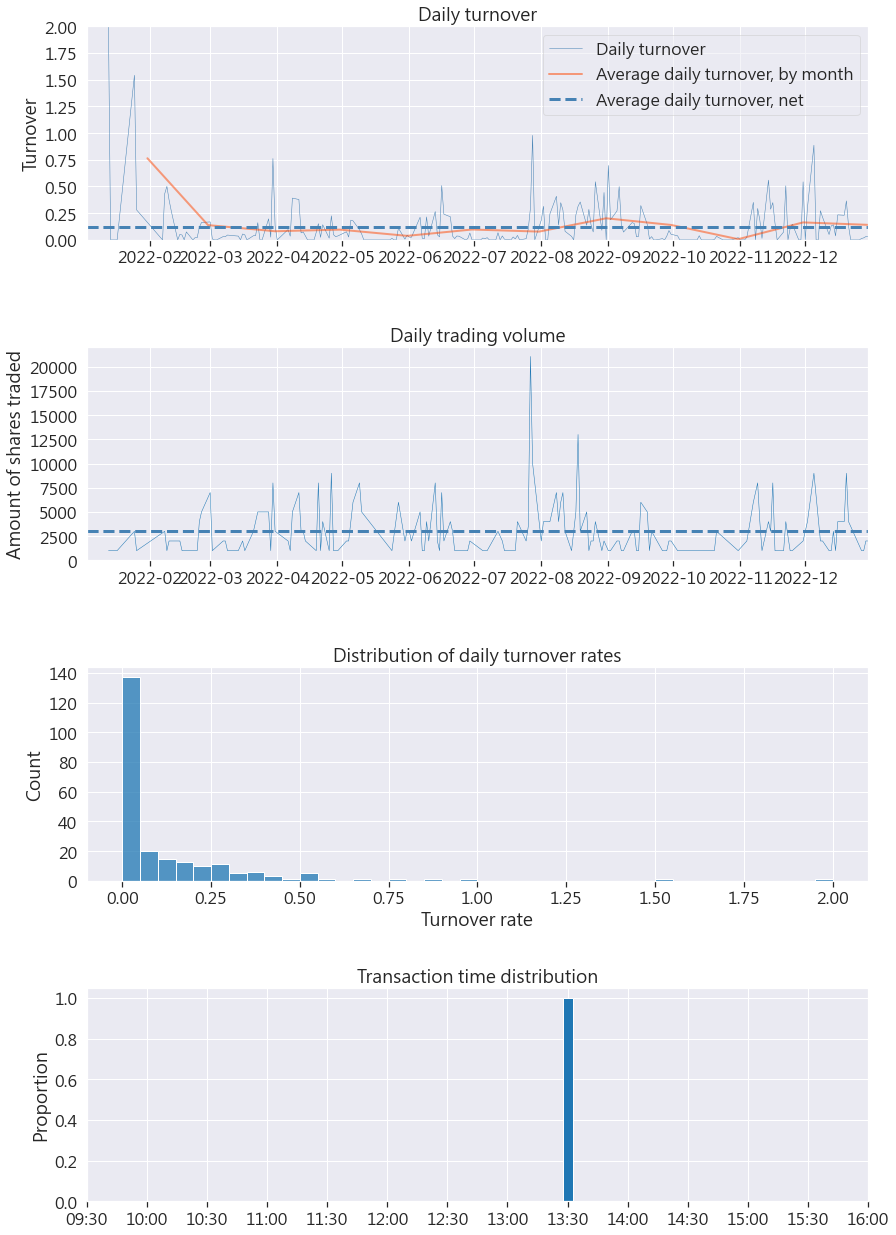

In [13]:
import pyfolio as pf

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                          benchmark_rets=benchmark_rets,
                          round_trips=False)